In [8]:
import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from torchdyn.datasets import *
from numpy.linalg import norm 
from tqdm import tqdm

In [9]:
import math

def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def normal_sample(n, dim, scale = 5, var=0.001):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    return scale * m.sample((n,))

class MLP(torch.nn.Module):
    def __init__(self, dim, w=512, time_varying=False, depth=3, out_dim=None):
        super().__init__()
        self.time_varying = time_varying
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.LeakyReLU(),
            *([torch.nn.Linear(w, w), torch.nn.LeakyReLU()] * depth),
            torch.nn.Linear(w, dim if out_dim is None else out_dim)
        )

    def forward(self, x):
        return self.net(x)
    



In [3]:
import torchdyn
from torchdyn.core import NeuralODE

class CNF(torch.nn.Module):
    def __init__(self, net, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.net = net
        self.trace_estimator = trace_estimator if trace_estimator is not None else autograd_trace
        self.noise_dist, self.noise = noise_dist, None

    def forward(self, t, x):
        with torch.set_grad_enabled(True):
            x_in = x[:, 1:].requires_grad_(
                True
            )  # first dimension reserved to divergence propagation
            # the neural network will handle the data-dynamics here
            x_out = self.net(torch.cat([x_in, t * torch.ones(x.shape[0], 1)], dim=-1))
            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return (
            torch.cat([-trJ[:, None], x_out], 1) + 0 * x
        )  # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph

    def backward(self, t, x, z):
        with torch.set_grad_enabled(True):
            x_in = x[:, 1:].requires_grad_(
                True
            )  # first dimension reserved to divergence propagation
            # the neural network will handle the data-dynamics here
            x_out = -self.net(torch.cat([x_in, t * torch.ones(x.shape[0], 1)], dim=-1))
            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return (
            torch.cat([-trJ[:, None], x_out], 1) + 0 * x
        )  # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph

In [22]:
import time

# First loss
sigma_min = 0.05
dim = 2
model_h = MLP(dim=dim, time_varying=True)

batch_size = 256
optimizer = torch.optim.Adam(model_h.parameters())

start = time.time()
for k in range(10_000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    
    x0 = eight_normal_sample(batch_size, dim, scale=5, var=0.1).float()
    x1, _ = generate_moons(batch_size, noise=0.2)
    #x1[:, 0] = x1[:, 0] - 0

    # sample some random times
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    M = M / M.max()
    # pi = pot.sinkhorn(a, b, M.detach().cpu().numpy(), reg=0.01)
    pi = pot.emd(a, b, M.detach().cpu().numpy(), 0.01)
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    i, j = np.divmod(choices, pi.shape[1])
    
    mu_t = x0[i] * (1 - t) + x1[j] * t
    sigma_t = sigma_min
    x = mu_t + sigma_t * normal_sample(batch_size, dim).float()
    ut = x1[j] - x0[i]
    vt = model_h(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if k % 100 == 0:
        end = time.time()
        print(f"{k}: loss {loss.item():0.3f} time {(end - start) / 100:0.2f}")
        start = end
        continue

0: loss 9.335 time 0.00
100: loss 0.113 time 0.02
200: loss 0.155 time 0.02
300: loss 0.180 time 0.02
400: loss 0.153 time 0.02
500: loss 0.132 time 0.02
600: loss 0.108 time 0.02
700: loss 0.124 time 0.02
800: loss 0.111 time 0.02
900: loss 0.124 time 0.02
1000: loss 0.082 time 0.02
1100: loss 0.101 time 0.02
1200: loss 0.100 time 0.02
1300: loss 0.180 time 0.02
1400: loss 0.229 time 0.02
1500: loss 0.122 time 0.02
1600: loss 0.083 time 0.02
1700: loss 0.142 time 0.02
1800: loss 0.082 time 0.02
1900: loss 0.134 time 0.02
2000: loss 0.151 time 0.02
2100: loss 0.087 time 0.02
2200: loss 0.073 time 0.02
2300: loss 0.110 time 0.02
2400: loss 0.121 time 0.02
2500: loss 0.161 time 0.02
2600: loss 0.062 time 0.02
2700: loss 0.086 time 0.02
2800: loss 0.055 time 0.02
2900: loss 0.104 time 0.02
3000: loss 0.099 time 0.02
3100: loss 0.063 time 0.02
3200: loss 0.055 time 0.02
3300: loss 0.093 time 0.02
3400: loss 0.065 time 0.02
3500: loss 0.081 time 0.02
3600: loss 0.069 time 0.02
3700: loss 0.

KeyboardInterrupt: 

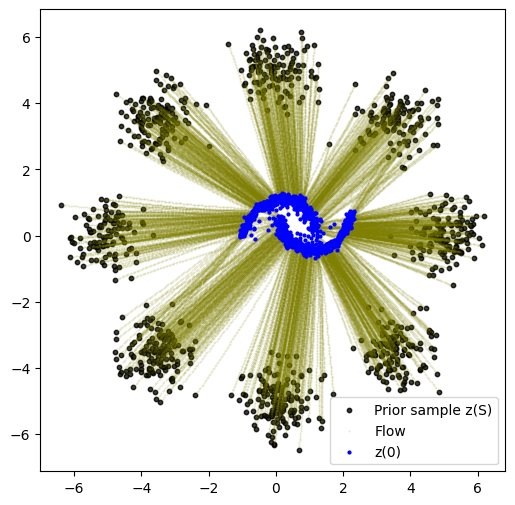

In [23]:

class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))



node_h = NeuralODE(
    torch_wrapper(model_h), solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)
dim = 2

source = eight_normal_sample(1 << 10, dim, scale=5, var=0.1).float()
full_traj = (
    node_h.trajectory(
        source,
        t_span=torch.linspace(0, 1, 100)
    )
    .detach()
    .cpu()
)
full_traj.shape
traj = full_traj
n = 2000
plt.figure(figsize=(6, 6))
plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()

In [16]:
def sample_spd_matrix(dim, eps=1):
    """
    Samples a random symmetric positive definite matrix (SPD) of size (dim x dim).
    
    Args:
    - dim (int): Dimension of the matrix.

    Returns:
    - torch.Tensor: Random SPD matrix of shape (dim, dim).
    """
    # Step 1: Generate a random matrix (A)
    A = torch.randn(dim, dim)

    # Step 2: Make the matrix symmetric positive definite (SPD) by multiplying A with its transpose
    spd_matrix = torch.mm(A, A.t())  # A * A^T ensures positive definiteness

    # Optional: Add a small value to the diagonal to ensure positive definiteness in case of numerical issues
    spd_matrix += torch.eye(dim) * eps

    return spd_matrix


In [27]:
import time
import itertools

# First loss
sigma_min = 0.05
dim = 2
rep_dim = 64

# model_r = MLP(dim=dim, out_dim=rep_dim, time_varying=False, w=64)
# model_h = MLP(dim=dim + rep_dim, out_dim=dim, time_varying=True)

batch_size = 256
# Combine the parameters from both models
combined_parameters = itertools.chain(model_h.parameters(), model_r.parameters())

# Use the combined parameters in the Adam optimizer
# optimizer = torch.optim.Adam(combined_parameters)

start = time.time()
for k in range(100_000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    
    x0 = eight_normal_sample(batch_size, dim, scale=5, var=0.1).float()
    x1, _ = generate_moons(batch_size, noise=0.2)
    Sigma = sample_spd_matrix(dim)
    x0 = x0 @ Sigma
    x1 = x1 @ Sigma
    #x1[:, 0] = x1[:, 0] - 0

    # sample some random times
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    M = M / M.max()
    # pi = pot.sinkhorn(a, b, M.detach().cpu().numpy(), reg=0.01)
    pi = pot.emd(a, b, M.detach().cpu().numpy(), 0.01)
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    i, j = np.divmod(choices, pi.shape[1])
    
    mu_t = x0[i] * (1 - t) + x1[j] * t
    sigma_t = sigma_min
    x = mu_t + sigma_t * normal_sample(batch_size, dim).float()
    ut = x1[j] - x0[i]

    batch_rep = torch.nn.LeakyReLU()(model_r(x0).mean(axis=0)).repeat(batch_size, 1)
    vt = model_h(torch.cat([x, batch_rep, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if k % 100 == 0:
        end = time.time()
        print(f"{k}: loss {loss.item():0.3f} time {(end - start) / 100:0.2f}")
        start = end
        continue

0: loss 0.127 time 0.00
100: loss 0.378 time 0.02
200: loss 1.171 time 0.02
300: loss 1.960 time 0.02
400: loss 0.251 time 0.02
500: loss 0.413 time 0.02
600: loss 0.896 time 0.02
700: loss 0.320 time 0.02
800: loss 3.553 time 0.02
900: loss 2.125 time 0.02
1000: loss 1.270 time 0.02
1100: loss 1.367 time 0.02
1200: loss 1.308 time 0.02
1300: loss 0.529 time 0.02
1400: loss 0.338 time 0.02
1500: loss 0.214 time 0.02
1600: loss 0.585 time 0.02
1700: loss 0.385 time 0.02
1800: loss 1.028 time 0.02
1900: loss 0.350 time 0.02
2000: loss 1.630 time 0.02
2100: loss 0.255 time 0.02
2200: loss 0.861 time 0.02
2300: loss 0.274 time 0.02
2400: loss 0.626 time 0.02
2500: loss 0.172 time 0.02
2600: loss 0.263 time 0.02
2700: loss 0.131 time 0.02
2800: loss 0.206 time 0.02
2900: loss 0.452 time 0.02
3000: loss 0.991 time 0.02
3100: loss 0.181 time 0.02
3200: loss 0.926 time 0.02
3300: loss 0.340 time 0.02
3400: loss 3.450 time 0.02
3500: loss 0.858 time 0.02
3600: loss 0.355 time 0.02
3700: loss 0.

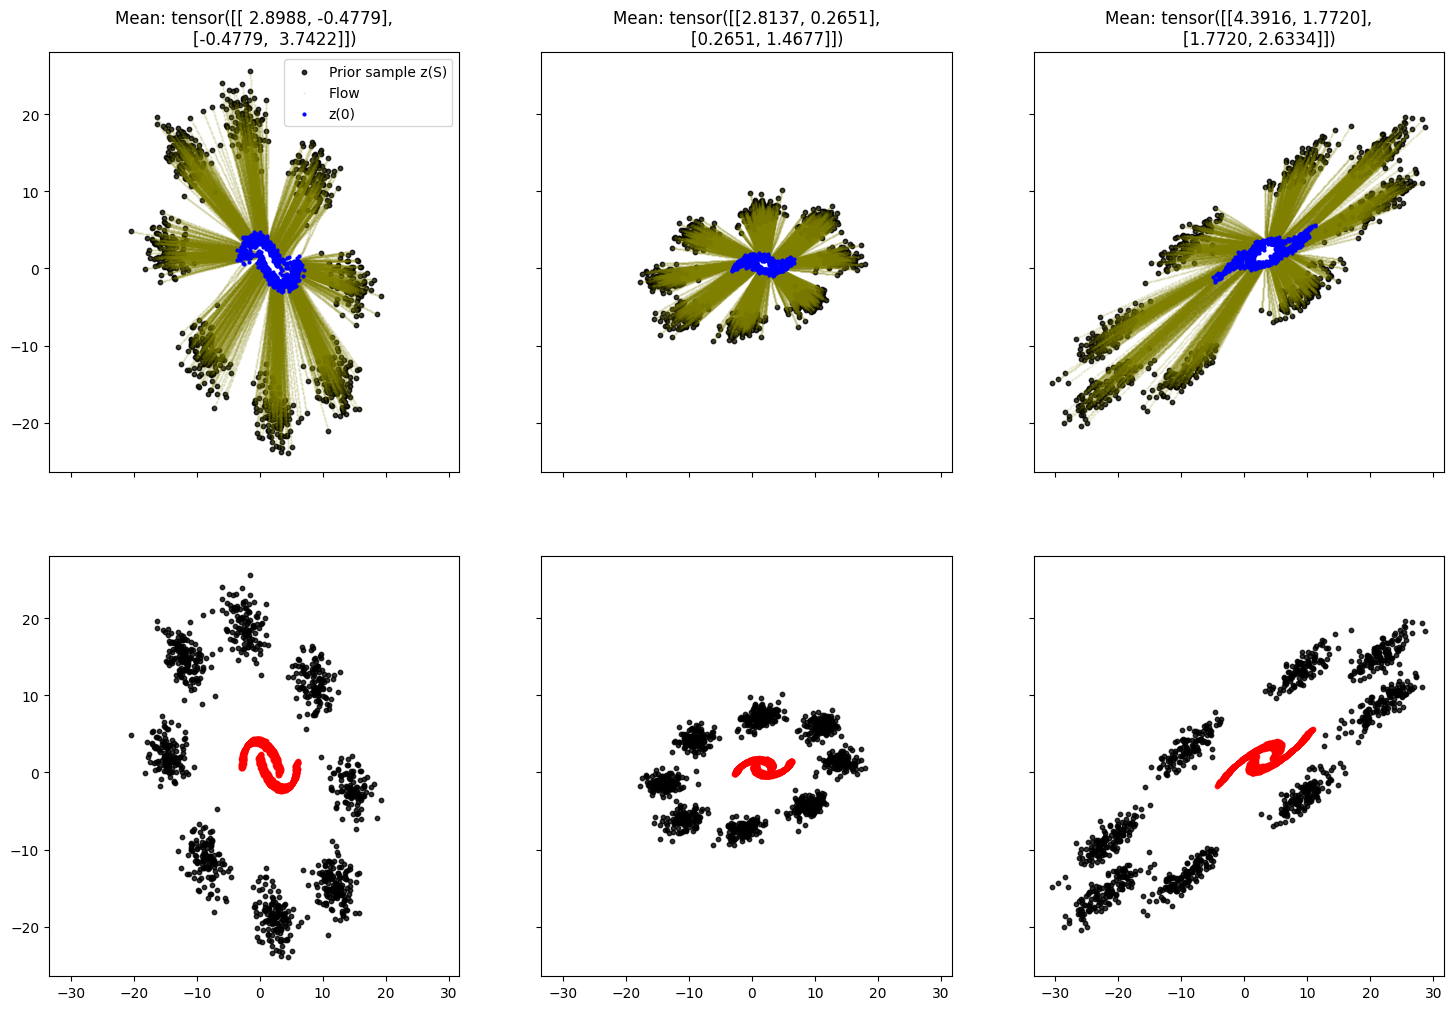

In [26]:

class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.rep = None

    def forward(self, t, x, *args, **kwargs):
        return self.model(torch.cat([x, self.rep, t.repeat(x.shape[0])[:, None]], 1))



wrapper = torch_wrapper(model_h)
node_h = NeuralODE(
    wrapper, solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)
dim = 2
n_source = 1 << 10

num_means = 3

# get figure for three different means
fig, axs = plt.subplots(2, 3, figsize=(6 * num_means, 6 * 2), sharex=True, sharey=True)
for i in range(num_means):
    source = eight_normal_sample(n_source, dim, scale=5, var=0.1).float()
    target = generate_moons(n_source, noise=0.2)[0]
    Sigma = sample_spd_matrix(dim)
    source = source @ Sigma
    target = target @ Sigma
    wrapper.rep = torch.nn.LeakyReLU()(model_r(source).mean(axis=0)).repeat(n_source, 1)
    full_traj = (
        node_h.trajectory(
            source,
            t_span=torch.linspace(0, 1, 100),
        )
        .detach()
        .cpu()
    )
    full_traj.shape
    traj = full_traj
    n = 2000
    axs[0, i].scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    axs[0, i].scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
    axs[0, i].scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
    axs[1, i].scatter(source[:n, 0], source[:n, 1], s=10, alpha=0.8, c="black")
    axs[1, i].scatter(target[:n, 0], target[:n, 1], s=10, alpha=0.8, c="red")
    axs[0, i].set_title(f"Mean: {Sigma}")
axs[0, 0].legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()

In [16]:
eg = eight_normal_sample(1 << 10, dim, scale=5, var=0.1).float()


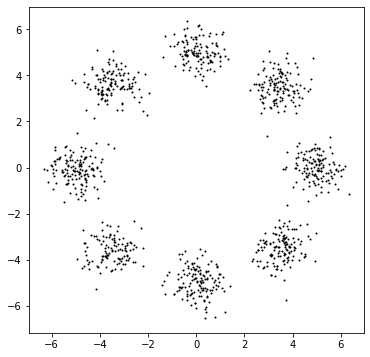

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(eg[:, 0], eg[:, 1], s=1, c="black")

In [18]:
import time

# First loss
sigma_min = 0.05
dim = 2
model_v = MLP(dim=dim, time_varying=True)

batch_size = 256
optimizer = torch.optim.Adam(model_v.parameters())

start = time.time()
for k in range(2000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    
    x0 = normalize_to_unit_cube(eight_normal_sample(batch_size, dim, scale=5, var=0.1)).float()
    x1 = normalize_to_unit_cube(normal_sample(batch_size, dim, scale=1, var=0.01)).float()
   
    # sample some random times
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    M = M / M.max()
    # pi = pot.sinkhorn(a, b, M.detach().cpu().numpy(), reg=0.01)
    pi = pot.emd(a, b, M.detach().cpu().numpy())
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    i, j = np.divmod(choices, pi.shape[1])
    
    mu_t = x0[i] * (1 - t) + x1[j] * t
    sigma_t = sigma_min
    x = mu_t + sigma_t * normal_sample(batch_size, dim).float()
    ut = x1[j] - x0[i]
    vt = model_v(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if k % 100 == 0:
        end = time.time()
        print(f"{k}: loss {loss.item():0.3f} time {(end - start) / 100:0.2f}")
        start = end
        continue

0: loss 0.096 time 0.00
100: loss 0.021 time 0.02
200: loss 0.018 time 0.02
300: loss 0.037 time 0.02
400: loss 0.009 time 0.02
500: loss 0.041 time 0.02
600: loss 0.013 time 0.02
700: loss 0.058 time 0.02
800: loss 0.010 time 0.02
900: loss 0.013 time 0.02
1000: loss 0.040 time 0.02
1100: loss 0.032 time 0.02
1200: loss 0.022 time 0.02
1300: loss 0.012 time 0.02
1400: loss 0.027 time 0.02
1500: loss 0.012 time 0.02
1600: loss 0.012 time 0.02
1700: loss 0.081 time 0.02
1800: loss 0.023 time 0.02
1900: loss 0.012 time 0.02


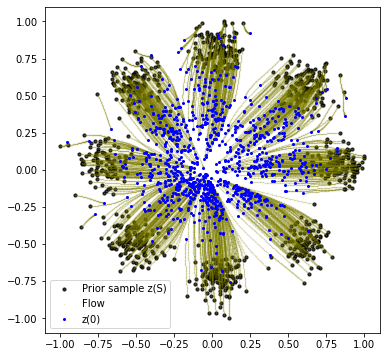

In [19]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


node_v = NeuralODE(
    torch_wrapper(model_v), solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)
dim = 2

source = normalize_to_unit_cube(eight_normal_sample(1 << 10, dim, scale=5, var=0.1).float())

full_traj = (
    node_v.trajectory(
        source,
        t_span=torch.linspace(0, 1, 100),
    )
    .detach()
    .cpu()
)
full_traj.shape
traj = full_traj
n = 2000
plt.figure(figsize=(6, 6))
plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()

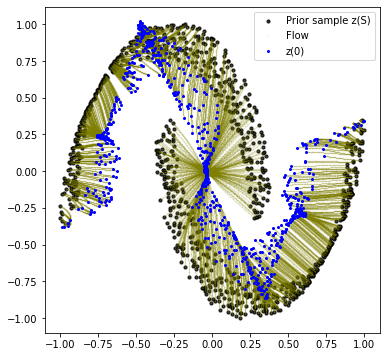

In [20]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))

moons, _ = generate_moons(1 << 10, noise=0.2)
moons = moons * 3 - 1
moons = normalize_to_unit_cube(moons)

node_v = NeuralODE(
    torch_wrapper(model_v), solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)
dim = 2
full_traj = (
    node_v.trajectory(
        moons.float(),
        t_span=torch.linspace(0, 1, 100),
    )
    .detach()
    .cpu()
)
full_traj.shape
traj = full_traj
n = 2000
plt.figure(figsize=(6, 6))
plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()

In [21]:
full_traj.shape

torch.Size([100, 1024, 2])

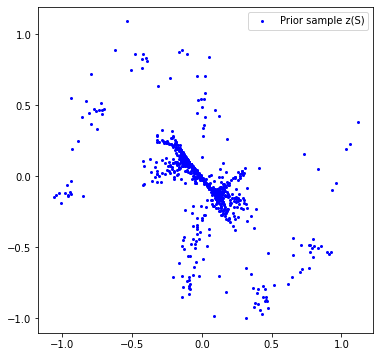

In [22]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


node_h = NeuralODE(
    torch_wrapper(model_h), solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)
dim = 2
source = normalize_to_unit_cube(normal_sample(1 << 10, dim, scale=1, var=0.01).float())

full_traj = (
    node_h.trajectory(
        source,
        t_span=torch.linspace(0, 1, 100),
    )
    .detach()
    .cpu()
)
full_traj.shape
traj = full_traj
n = 2000
plt.figure(figsize=(6, 6))
#plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
#plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()

## Product flow

This is the idea that $P(t, 0) = H(t)$ and $P(0, s) = V(s)$
$$
\begin{array}{c}
A \;(\text{8-Guassians}) \xrightarrow{\qquad H(t) \qquad} B \;(\text{2-moons}) \\
\qquad\Bigg\downarrow{V(s)}\qquad\qquad\qquad\qquad \Bigg\downarrow{V(s)}\;\; \\
C\;(\text{1- Guassian}) \xrightarrow{\qquad H(t) \qquad} D \; (?)
\end{array}
$$
We will train a product flow network $P(t, s)$, so that when $(t, s) = (t, 0)$, we then sample $(x_0, x_1)$ from horizontal distributions $A$ and $B$, i.e., $(x_0, x_1) \sim (A, B)$, and denote $(x_0, x_1) := (x_a, x_b)$ so that 
$$x_h = tx_b + (1-t)x_a.$$
When $(t, s) = (0, s)$, we then sample $(x_0, x_1)$ from vertical distributions $A$ and $C$, i.e., $(x_0, x_1) \sim (A, C)$, and denote $(x_0, x_1) := (x_a, x_c)$ so that 
$$x_v = sx_c + (1-s)x_a.$$ 
But when $(t, s)$ is not above cases, then we sample
$$\frac{1}{2}\left[sx_c + (1 - s)(tx_b + (1-t)x_a)\right] + \frac{1}{2}\left[tx_b + (1 - t)(sx_c + (1-s)x_a)\right]$$

In [24]:
class MLP_Product(torch.nn.Module):
    def __init__(self, dim, w=512, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (2 if time_varying else 0), w),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(w, w),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(w, w),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(w, w),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(w, dim),
        )

    def forward(self, x):
        return self.net(x)


In [25]:
import time

# First loss
sigma_min = 0.05
dim = 2
model_p = MLP_Product(dim=dim, time_varying=True)

batch_size = 256
optimizer = torch.optim.Adam(model_p.parameters())

start = time.time()
for k in tqdm(range(2000)):
    optimizer.zero_grad()
    
    ts = torch.rand(batch_size, 2)
    
    xa = eight_normal_sample(batch_size, dim, scale=5, var=0.1).float()
    xa = normalize_to_unit_cube(xa)
    xb, _ = generate_moons(batch_size, noise=0.2)
    xb = xb * 3 - 1
    xb = normalize_to_unit_cube(xb)
    xc = normal_sample(batch_size, dim, scale=1, var=0.01).float()
    xc = normalize_to_unit_cube(xc)
    
    # On the horizontal OT pairing
    a, b = pot.unif(xa.size()[0]), pot.unif(xb.size()[0])
    Mh = torch.cdist(xa, xb) ** 2
    Mh = Mh / Mh.max()
    # pi = pot.sinkhorn(a, b, M.detach().cpu().numpy(), reg=0.01)
    pi_h = pot.emd(a, b, Mh.detach().cpu().numpy())
    # Sample random interpolations on pi
    p_h = pi_h.flatten()
    p_h = p_h / p_h.sum()
    choices_h = np.random.choice(pi_h.shape[0] * pi_h.shape[1], p=p_h, size=batch_size)
    i_h, j_h = np.divmod(choices_h, pi_h.shape[1])
    
    # On the vertical OT pairing
    a, c = pot.unif(xa.size()[0]), pot.unif(xc.size()[0])
    Mv = torch.cdist(xa, xc) ** 2
    Mv = Mv / Mv.max()
    # pi = pot.sinkhorn(a, b, M.detach().cpu().numpy(), reg=0.01)
    pi_v = pot.emd(a, c, Mv.detach().cpu().numpy())
    # Sample random interpolations on pi
    p_v = pi_v.flatten()
    p_v = p_v / p_v.sum()
    choices_v = np.random.choice(pi_v.shape[0] * pi_v.shape[1], p=p_v, size=batch_size)
    i_v, j_v = np.divmod(choices_v, pi_v.shape[1])
    
    
    # horizontal condition
    t = ts[:,0].unsqueeze(dim = 1)
    mu_t = xa[i_h] * (1 - t) + xb[j_h] * t
    sigma_t = sigma_min
    xt = mu_t + sigma_t * normal_sample(batch_size, dim).float()
    
    # vertical condition 
    s = ts[:,1].unsqueeze(dim = 1)
    mu_s = xa[i_v] * (1 - s) + xc[j_v] * s
    sigma_s = sigma_min
    xs = mu_s + sigma_s * normal_sample(batch_size, dim).float()
    
    # conbined condition
    
    x = 1/2 * (s * xc[j_v] + (1 - s) * xt) + 1/2 * (t * xb[j_h] + (1 - t) * xs)
    
    
    uts = (t * (xb[j_h] - xa[i_h]) + s * (xc[j_v] - xa[i_v]))/(t ** 2 + s ** 2) ** 0.5 
    vts = model_p(torch.cat([x, ts], dim=-1))
    loss = torch.mean((vts - uts) ** 2)
    loss.backward()
    optimizer.step()
    #if k % 100 == 0:
    #    end = time.time()
    #    print(f"{k}: loss {loss.item():0.3f} time {(end - start) / 100:0.2f}")
    #    start = end
    #    continue

100%|██████████| 2000/2000 [03:29<00:00,  9.55it/s]


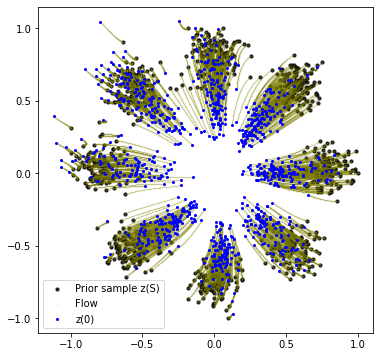

In [27]:
class torch_wrapper_p(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model, alongt=False, alongs=True, time_value=0.0):
        super().__init__()
        self.model = model
        self.alongt = alongt
        self.alongs = alongs
        self.time_value = time_value

    def forward(self, t, x):
        time_fix = torch.tensor(self.time_value).repeat(x.shape[0])[:, None]  # Fixed time value

        if self.alongt:
            ts = torch.cat([t.repeat(x.shape[0])[:, None], time_fix], dim=1)
        elif self.alongs:
            ts = torch.cat([time_fix, t.repeat(x.shape[0])[:, None]], dim=1)
        else:
            raise ValueError("Either alongt or alongs must be True.")

        return self.model(torch.cat([x, ts], dim=1))  # Correct concatenation

# Example usage
node_p = NeuralODE(
    torch_wrapper_p(model_p), solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)

dim = 2

source = normalize_to_unit_cube(eight_normal_sample(1 << 10, dim, scale=5, var=0.1).float())
full_traj = (
    node_p.trajectory(
        source,
        t_span=torch.linspace(0, 1, 100),
    )
    .detach()
    .cpu()
)
traj = full_traj

# Plotting
n = 2000
plt.figure(figsize=(6, 6))
plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()


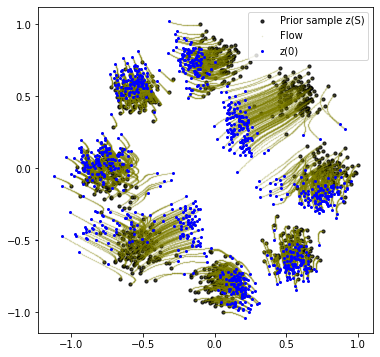

In [28]:
class torch_wrapper_p(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model, alongt=True, alongs=False, time_value=0.0):
        super().__init__()
        self.model = model
        self.alongt = alongt
        self.alongs = alongs
        self.time_value = time_value

    def forward(self, t, x):
        time_fix = torch.tensor(self.time_value).repeat(x.shape[0])[:, None]  # Fixed time value

        if self.alongt:
            ts = torch.cat([t.repeat(x.shape[0])[:, None], time_fix], dim=1)
        elif self.alongs:
            ts = torch.cat([time_fix, t.repeat(x.shape[0])[:, None]], dim=1)
        else:
            raise ValueError("Either alongt or alongs must be True.")

        return self.model(torch.cat([x, ts], dim=1))  # Correct concatenation

# Example usage
node_p = NeuralODE(
    torch_wrapper_p(model_p), solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)

dim = 2
source = normalize_to_unit_cube(eight_normal_sample(1 << 10, dim, scale=5, var=0.1).float())

full_traj = (
    node_p.trajectory(
        source,
        t_span=torch.linspace(0, 1, 100),
    )
    .detach()
    .cpu()
)
traj = full_traj

# Plotting
n = 2000
plt.figure(figsize=(6, 6))
plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()


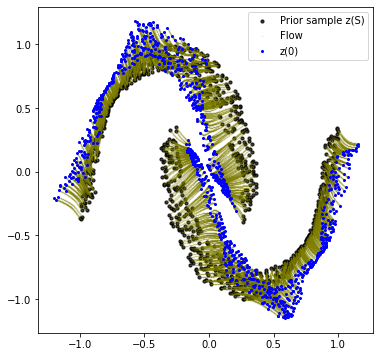

In [50]:
class torch_wrapper_p(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model, alongt=False, alongs=True, time_value=1.0):
        super().__init__()
        self.model = model
        self.alongt = alongt
        self.alongs = alongs
        self.time_value = time_value

    def forward(self, t, x):
        time_fix = torch.tensor(self.time_value).repeat(x.shape[0])[:, None]  # Fixed time value

        if self.alongt:
            ts = torch.cat([t.repeat(x.shape[0])[:, None], time_fix], dim=1)
        elif self.alongs:
            ts = torch.cat([time_fix, t.repeat(x.shape[0])[:, None]], dim=1)
        else:
            raise ValueError("Either alongt or alongs must be True.")

        return self.model(torch.cat([x, ts], dim=1))  # Correct concatenation

# Example usage
node_p = NeuralODE(
    torch_wrapper_p(model_p), solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)

dim = 2
moons, _ = generate_moons(1 << 10, noise=0.2)
moons = moons * 3 - 1
source = normalize_to_unit_cube(moons.float())

full_traj = (
    node_p.trajectory(
        source,
        t_span=torch.linspace(0, 1, 100),
    )
    .detach()
    .cpu()
)
traj = full_traj

# Plotting
n = 2000
plt.figure(figsize=(6, 6))
plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()


In [ ]:
class torch_wrapper_p(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model, alongt=True, alongs=False, time_value=1.0):
        super().__init__()
        self.model = model
        self.alongt = alongt
        self.alongs = alongs
        self.time_value = time_value

    def forward(self, t, x):
        time_fix = torch.tensor(self.time_value).repeat(x.shape[0])[:, None]  # Fixed time value

        if self.alongt:
            ts = torch.cat([t.repeat(x.shape[0])[:, None], time_fix], dim=1)
        elif self.alongs:
            ts = torch.cat([time_fix, t.repeat(x.shape[0])[:, None]], dim=1)
        else:
            raise ValueError("Either alongt or alongs must be True.")

        return self.model(torch.cat([x, ts], dim=1))  # Correct concatenation

# Example usage
node_p = NeuralODE(
    torch_wrapper_p(model_p), solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)

dim = 2

source = normalize_to_unit_cube(normal_sample(1 << 10, dim, scale=1, var=0.01).float())

full_traj = (
    node_p.trajectory(
        source,
        t_span=torch.linspace(0, 1, 100),
    )
    .detach()
    .cpu()
)
traj = full_traj

# Plotting
n = 2000
plt.figure(figsize=(6, 6))
#plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
#plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()


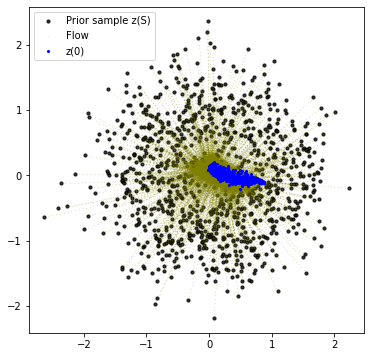

In [21]:
class torch_wrapper_p(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model, alongt=True, alongs=False, time_value=1.0):
        super().__init__()
        self.model = model
        self.alongt = alongt
        self.alongs = alongs
        self.time_value = time_value

    def forward(self, t, x):
        time_fix = torch.tensor(self.time_value).repeat(x.shape[0])[:, None]  # Fixed time value

        if self.alongt:
            ts = torch.cat([t.repeat(x.shape[0])[:, None], time_fix], dim=1)
        elif self.alongs:
            ts = torch.cat([time_fix, t.repeat(x.shape[0])[:, None]], dim=1)
        else:
            raise ValueError("Either alongt or alongs must be True.")

        return self.model(torch.cat([x, ts], dim=1))  # Correct concatenation

# Example usage
node_p = NeuralODE(
    torch_wrapper_p(model_p), solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)

dim = 2

full_traj = (
    node_p.trajectory(
        eight_normal_sample(1 << 10, dim, scale=1, var=0.05).float(),
        t_span=torch.linspace(0, 1, 100),
    )
    .detach()
    .cpu()
)
traj = full_traj

# Plotting
n = 2000
plt.figure(figsize=(6, 6))
plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()


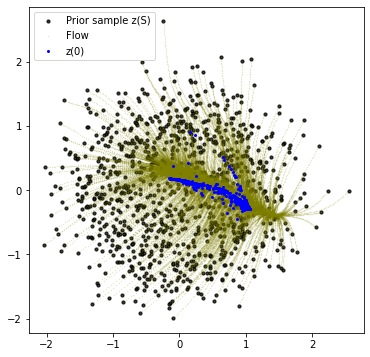

In [36]:
class torch_wrapper_p(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model, alongt=False, alongs=True, time_value=1.0):
        super().__init__()
        self.model = model
        self.alongt = alongt
        self.alongs = alongs
        self.time_value = time_value

    def forward(self, t, x):
        time_fix = torch.tensor(self.time_value).repeat(x.shape[0])[:, None]  # Fixed time value

        if self.alongt:
            ts = torch.cat([t.repeat(x.shape[0])[:, None], time_fix], dim=1)
        elif self.alongs:
            ts = torch.cat([time_fix, t.repeat(x.shape[0])[:, None]], dim=1)
        else:
            raise ValueError("Either alongt or alongs must be True.")

        return self.model(torch.cat([x, ts], dim=1))  # Correct concatenation

# Example usage
node_p = NeuralODE(
    torch_wrapper_p(model_p), solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)

dim = 2

full_traj = (
    node_p.trajectory(
        eight_normal_sample(1 << 10, dim, scale=1, var=0.05).float(),
        t_span=torch.linspace(0, 1, 100),
    )
    .detach()
    .cpu()
)
traj = full_traj

# Plotting
n = 2000
plt.figure(figsize=(6, 6))
plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()
